In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('video data summaries.xlsx', sheet_name = '29Sep_1-20Tricaine')
print(len(data))
data = data[data.Include==True]
print(len(data))
data.head(3)

80
77


,Clip,Scale,Initials,Date,Treatment,Tardigrade,ClipDuration,ClipArea,VidArea,Distance,Turns,AngleSpace,Stops,Include
0,AC_Sep29_nodrug_tardigrade3-1,478.05,AC,2022-09-29,nodrug,3,49.80,2332.0,2291.5,1305.53,1,446.43,1,True
1,AC_Sep29_nodrug_tardigrade3-2,478.05,AC,2022-09-29,nodrug,3,44.73,2242.5,2291.5,963.75,4,1632.62,3,True
2,GI_29sep_nodrug_tardigrade1-1,478.46,GI,2022-09-29,nodrug,1,21.60,3531.5,3518.5,756.49,1,156.72,0,True


In [3]:
# divide data into control and treatment experiments
control = data[data.Treatment.isin(['predrug_control','nodrug'])]
treatment = data[data.Treatment.isin(['predrug_treatment','tricaine1-20'])]
print(len(data), len(control), len(treatment), len(control) + len(treatment))

77 25 52 77


In [4]:
def getDataDict(df, comparison1, comparison2):
    dataDict = {}

    dataDict[comparison1] = {}
    dataDict[comparison2] = {}

    dataDict[comparison1]['area'] = np.array([])
    dataDict[comparison2]['area'] = np.array([])

    dataDict[comparison1]['speed'] = np.array([])
    dataDict[comparison2]['speed'] = np.array([])

    dataDict[comparison1]['turns'] = np.array([])
    dataDict[comparison2]['turns'] = np.array([])

    dataDict[comparison1]['angles'] = np.array([])
    dataDict[comparison2]['angles'] = np.array([])

    dataDict[comparison1]['stops'] = np.array([])
    dataDict[comparison2]['stops'] = np.array([])

    data1 = data[data.Treatment == comparison1]
    data2 = data[data.Treatment == comparison2]

    # go through each person
    print('in scale t spd  tur ang stop')
    for person in sorted(np.unique(data.Initials)):

        persondata1 = data1[data1.Initials==person]
        persondata2 = data2[data2.Initials==person]

        # get tardigrades for this person
        tardigrades1 = sorted(np.unique(persondata1['Tardigrade'].values))
        tardigrades2 = sorted(np.unique(persondata2['Tardigrade'].values))

        # go through each tardigrade
        if len(tardigrades1) > 0:

            scale = persondata1.Scale.values[0]

            for tardigrade in tardigrades1:

                tardigradedata1 = persondata1[persondata1.Tardigrade==tardigrade]
                tardigradedata2 = persondata2[persondata2.Tardigrade==tardigrade]

                # area
                area1 = np.median(tardigradedata1.VidArea.values)
                area2 = np.median(tardigradedata2.VidArea.values)

                scaled_area1 = area1 / scale**2
                scaled_area2 = area2 / scale**2

                dataDict[comparison1]['area'] = np.append(dataDict[comparison1]['area'], scaled_area1)
                dataDict[comparison2]['area'] = np.append(dataDict[comparison2]['area'], scaled_area2)

                # speed (Distance / ClipDuration)
                distance1 = np.sum(tardigradedata1.Distance.values)
                distance2 = np.sum(tardigradedata2.Distance.values)
                scaled_distance1 = distance1 / scale
                scaled_distance2 = distance2 / scale

                clipduration1 = np.sum(tardigradedata1.ClipDuration.values)
                clipduration2 = np.sum(tardigradedata2.ClipDuration.values)

                speed1 = scaled_distance1 / clipduration1
                speed2 = scaled_distance2 / clipduration2

                dataDict[comparison1]['speed'] = np.append(dataDict[comparison1]['speed'], speed1)
                dataDict[comparison2]['speed'] = np.append(dataDict[comparison2]['speed'], speed2)

                # Turns / second (Turns / ClipDuration)
                turns1 = np.sum(tardigradedata1.Turns.values)
                turns2 = np.sum(tardigradedata2.Turns.values)

                turns_per_sec1 = turns1 / clipduration1
                turns_per_sec2 = turns2 / clipduration2

                dataDict[comparison1]['turns'] = np.append(dataDict[comparison1]['turns'], turns_per_sec1)
                dataDict[comparison2]['turns'] = np.append(dataDict[comparison2]['turns'], turns_per_sec2)

                # Angles / second (AngleSpace / ClipDuration)
                angles1 = np.sum(tardigradedata1.AngleSpace.values)
                angles2 = np.sum(tardigradedata2.AngleSpace.values)

                angles_per_sec1 = angles1 / clipduration1
                angles_per_sec2 = angles2 / clipduration2

                dataDict[comparison1]['angles'] = np.append(dataDict[comparison1]['angles'], angles_per_sec1)
                dataDict[comparison2]['angles'] = np.append(dataDict[comparison2]['angles'], angles_per_sec2)

                # Stops / second (Stops / ClipDuration)
                stops1 = np.sum(tardigradedata1.Stops.values)
                stops2 = np.sum(tardigradedata2.Stops.values)
    #             print(person, tardigrade, stops1, stops2)

                stops_per_sec1 = stops1 / clipduration1
                stops_per_sec2 = stops2 / clipduration2

                dataDict[comparison1]['stops'] = np.append(dataDict[comparison1]['stops'], stops_per_sec1)
                dataDict[comparison2]['stops'] = np.append(dataDict[comparison2]['stops'], stops_per_sec2)

                print(person, scale, tardigrade, speed1, turns_per_sec1, angles_per_sec1, stops_per_sec1)
                print(person, scale, tardigrade, speed2, turns_per_sec2, angles_per_sec2, stops_per_sec2)
            
    return dataDict

def pairedPlot(data, comparison1, comparison2, to_plot, ylab='vals'):

    # plot parameters to change
    f, a1 = plt.subplots(1,1,figsize = (3,5))
    change_threshold = 0.2 # what is considered a change? 10%? 20%? 
    comparison_changes = np.array([0,0,0,0]) # zeros, decreases, sames, increases
    comparison_colors = ['lightgray','tomato','gold','forestgreen']
    
    dataDict = getDataDict(data,comparison1,comparison2)
    dataset1 = dataDict[comparison1][to_plot]
    dataset2 = dataDict[comparison2][to_plot]

    for i,point in enumerate(dataset1):
        val1 = point
        val2 = dataset2[i]
        if val2 > (1 + change_threshold) * val1: # an increase
            comp_change_index = 3
        elif val2 < (1 - change_threshold) * val1: # a decrease
            comp_change_index = 1
        else:
            comp_change_index = 2
        comparison_changes[comp_change_index] += 1
        a1.plot([1,2],[val1, val2],'--', color = comparison_colors[comp_change_index])
        a1.plot(1, val1,'ko') 
        a1.plot(2, val2,'ko')


    a1.set_ylabel(ylab, fontsize = 24)
    # a1.set_ylabel(to_plot, fontsize = 24)
    a1.set_xticks(ticks=[1,2], labels = ['pre treatment', comparison2], fontsize=16)
    a1.set_xlim([0.8,2.2])
    
    plt.show()
    return comparison_changes, comparison_colors

in scale t spd  tur ang stop
AC 478.05 3 0.03348338000328061 0.03738783649052841 7.967098703888333 0.02492522432701894
AC 478.05 3 0.05021634566525808 0.05289326139849783 21.99354702210938 0.042314609118798266
GI 478.46 1 0.05019797507949042 0.09055627425614488 29.08395860284605 0.025873221216041395
GI 478.46 1 0.07110482747243516 0.028129395218002808 7.662165963431785 0.0
IG 468.72 2 0.03919345207562857 0.16313213703099508 23.09194720450838 0.05932077710218003
IG 468.72 2 0.013938272558444358 0.33519553072625696 54.118528864059584 0.13966480446927373
MF 501.08 3 0.10077753703561235 0.012588116817724069 5.149169184290031 0.0377643504531722
MF 501.08 3 0.09969116675590312 0.010796804145972791 7.2600950118764835 0.021593608291945583


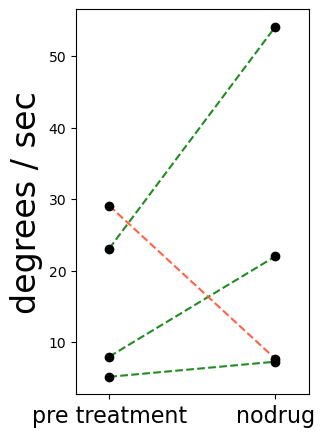

In [18]:
# plot for CONTROL
to_plot = 'angles' # area speed stops turns angles
ylab = 'degrees / sec' # tardigrade size\n(mm^2) speed (mm/sec) stops / sec turns / sec degrees / sec
control_changes, comparison_colors = pairedPlot(data, 'predrug_control', 'nodrug', to_plot, ylab)

in scale t spd  tur ang stop
AC 478.05 1 0.06909809125136863 0.03080240258740182 9.595564454027414 0.04620360388110273
AC 478.05 1 0.07414327644670905 0.18297276934667958 48.53191260359488 0.12915724895059735
AC 478.05 2 0.05722134826165404 0.12714558169103624 16.344705799251255 0.09889100798191708
AC 478.05 2 0.025595038183282147 0.0799552250739586 18.66874550251859 0.06396418005916688
GI 478.46 2 0.06528699015367315 0.08614191881124152 12.100786045009151 0.04307095940562076
GI 478.46 2 0.03436006284980428 0.14054813773717498 56.93724525650035 0.1335207308503162
GI 478.46 3 0.08064589699457378 0.016059097478721696 13.252449012365506 0.08029548739360848
GI 478.46 3 0.09883471742551081 0.013723068478111704 12.313983806779195 0.05489227391244682
IG 468.72 1 0.06879707241220032 0.06028454304316373 10.450566674704607 0.06028454304316373
IG 468.72 1 0.1072755414337385 0.0547945205479452 7.424657534246576 0.0547945205479452
LA 459.07 1 0.11555824364679136 0.0550478916657492 10.17395133766376

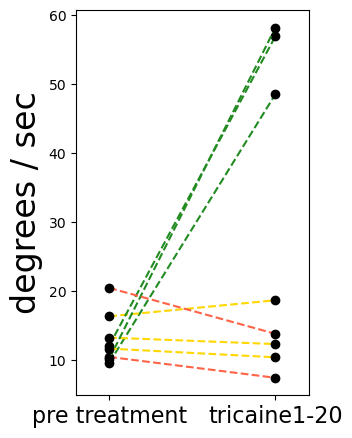

[1 2 3 3]


In [19]:
# plot for DRUG
treatment = 'tricaine1-20'
drug_changes, comparison_colors = pairedPlot(data, 'predrug_treatment', treatment, to_plot, ylab)
drug_changes[0] = 1 # how many stopped moving?
print(drug_changes)

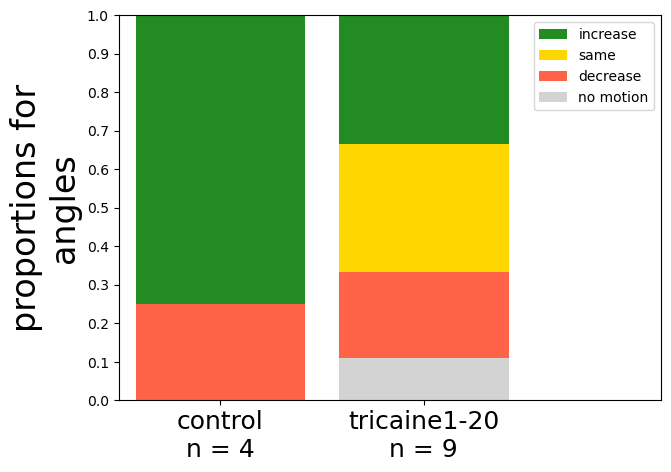

In [20]:
# stacked bar chart showing stops, decreases, same, increases
comparison_labels = ['no motion','decrease','same','increase']
control_proportions = control_changes/np.sum(control_changes)
drug_proportions = drug_changes/np.sum(drug_changes)

f,a2 = plt.subplots(1,1,figsize=(7,5))
xlocs = [1,1.6]

# plot controls
current_bottom = 0
for i,prop in enumerate(control_proportions):
    a2.bar(xlocs[0], prop, bottom=current_bottom, label=comparison_labels[i], width = 0.5, color=comparison_colors[i])
    current_bottom += prop
    
# plot drug treated
current_bottom = 0
for i,prop in enumerate(drug_proportions):
    a2.bar(xlocs[1], prop, bottom=current_bottom, width = 0.5, color=comparison_colors[i])
    current_bottom += prop

n_control = np.sum(control_changes)
n_drug = np.sum(drug_changes)
xlab_control = 'control\nn = ' + str(n_control)
xlab_drug = treatment + '\nn = ' + str(n_drug)
    
handles, labels = a2.get_legend_handles_labels()
a2.legend(reversed(handles), reversed(labels))
a2.set_xlim([0.7,2.3])
a2.set_ylim([0,1])
a2.set_yticks(np.linspace(0,1,11),fontsize=18)
a2.set_xticks(xlocs,[xlab_control,xlab_drug],fontsize=18)
a2.set_ylabel('proportions for\n' + to_plot, fontsize=24)

plt.show()

## 